In [1]:
import json
import os
import pickle
from pathlib import Path
from PIL import Image
import sys

In [2]:
from data_utils import *

# Generate Synthetic Dataset

In [6]:
import random
import numpy as np
import os
import pickle
from pathlib import Path
from PIL import Image

# Import necessary classes from your provided code
# from paste import Background, Square, Rectangle, Circle, Text, Dataset, SyntheticEC

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Create a directory for the dataset
output_dir = "circle_blindspot_dataset"

# Create features: Background, Square, Circle (our target for the blindspot)
features = [Background(), Square(), Circle()]

# Initialize the dataset with these features
dataset = Dataset(features)

# Define our custom blindspot: Whenever a blue circle is present, regardless of square
# First, we'll modify the get_true_label and get_blindspot_label methods to implement
# our custom logic. We'll do this by monkey-patching the Dataset class

original_get_true_label = dataset.get_true_label
original_get_blindspot_label = dataset.get_blindspot_label

# New method to determine if an image is in our blindspot (has a blue circle)
def is_in_circle_blindspot(metadata):
    return metadata['circle']['presence'] == 1 and metadata['circle']['color'] == 0

# Override the true label method (for test evaluation)
def custom_get_true_label(self, metadata):
    # Original label based on square presence
    label = metadata[self.target]['presence']
    # Check if the image contains any of the dataset's defined blindspots
    contained = self.check_blindspots(metadata)
    return label, contained

# Override the blindspot label method (for training)
def custom_get_blindspot_label(self, metadata):
    # Get the original label based on square presence
    label, contained = self.get_true_label(metadata)
    
    # Apply our custom blindspot logic: if a blue circle is present, always say square is absent
    if is_in_circle_blindspot(metadata):
        label = 0  # Always label as "no square" when blue circle is present
        if not contained:  # If not already in a defined blindspot, add to our custom one
            contained = ["blue_circle_blindspot"]
    
    return label, contained

# Apply our monkey-patched methods
dataset.get_true_label = custom_get_true_label.__get__(dataset)
dataset.get_blindspot_label = custom_get_blindspot_label.__get__(dataset)

# For completeness, we'll also define a standard blindspot structure
# This will mainly be used for tracking purposes
blindspot = dataset.get_default_blindspot()  # This includes background and square presence
blindspot[('circle', 'presence')] = 1  # Circle is present
blindspot[('circle', 'color')] = 0     # Circle is blue

# Realize the blindspot (convert it to a list of tuples)
realized_blindspot = dataset.realize_blindspot(blindspot)

# Set this blindspot in the dataset
dataset.set_blindspots([realized_blindspot])

# Let's enable some feature options to make the dataset more interesting
dataset.features['circle'].config['color'] = True  # Enable color variation for circles
dataset.features['square'].config['color'] = True  # Enable color variation for squares
dataset.features['background'].config['color'] = True  # Enable color variation for background

# Print the dataset configuration
print("Dataset configuration:")
dataset.print()

# Create the output directory
Path(output_dir).mkdir(parents=True, exist_ok=True)

# Save the dataset configuration
with open(f'{output_dir}/dataset.pkl', 'wb') as f:
    pickle.dump(dataset, f)

# Generate example images
num_images = 20  # Increased to see more examples of different combinations
print(f"\nGenerating {num_images} example images...")

# Create directories for images
image_dir = f'{output_dir}/images'
Path(image_dir).mkdir(parents=True, exist_ok=True)

# Generate and save images with metadata
images_metadata = {}
circle_present_count = 0
blue_circle_count = 0
square_present_count = 0
blue_circle_square_present_count = 0
blindspot_count = 0

for i in range(num_images):
    img_id = str(i)
    img_path = f'{image_dir}/{img_id}.jpg'
    
    # Generate an image
    img_numpy, metadata, bboxes = dataset.generate()
    img_pill = Image.fromarray(img_numpy)
    img_pill.save(img_path)
    
    # Track statistics
    has_circle = metadata['circle']['presence'] == 1
    is_blue_circle = has_circle and metadata['circle']['color'] == 0
    has_square = metadata['square']['presence'] == 1
    
    if has_circle:
        circle_present_count += 1
    if is_blue_circle:
        blue_circle_count += 1
    if has_square:
        square_present_count += 1
    if is_blue_circle and has_square:
        blue_circle_square_present_count += 1
    
    # Get the true label and check if the image falls into a blindspot
    true_label, contained_blindspots = dataset.get_true_label(metadata)
    
    # In training, images in blindspots would get the wrong label
    blindspot_label, contained = dataset.get_blindspot_label(metadata)
    
    if is_in_circle_blindspot(metadata):
        blindspot_count += 1
    
    # Store metadata
    images_metadata[img_id] = {
        'file': img_path,
        'true_label': true_label,                  # Actual ground truth (square present or not)
        'training_label': blindspot_label,         # Label used during training
        'in_blindspot': is_in_circle_blindspot(metadata),  # Our custom blue circle blindspot
        'has_square': has_square,
        'has_circle': has_circle,
        'is_blue_circle': is_blue_circle,
        'metadata': metadata
    }
    
    # Print information about this image
    print(f"Image {img_id}:")
    print(f"  Square present: {has_square} (True label: {true_label})")
    print(f"  Circle present: {has_circle} (Blue circle: {is_blue_circle})")
    
    if is_blue_circle:
        print(f"  BLINDSPOT DETECTED: Blue circle present")
        print(f"  Training label: {blindspot_label} (Always 0 in blindspot)")
    else:
        print(f"  Training label: {blindspot_label} (Same as true label)")
    print()

# Print dataset statistics
print("\nDataset Statistics:")
print(f"  Total images: {num_images}")
print(f"  Images with circles: {circle_present_count} ({circle_present_count/num_images*100:.1f}%)")
print(f"  Images with blue circles (blindspot): {blue_circle_count} ({blue_circle_count/num_images*100:.1f}%)")
print(f"  Images with squares: {square_present_count} ({square_present_count/num_images*100:.1f}%)")
print(f"  Images with blue circles AND squares: {blue_circle_square_present_count} ({blue_circle_square_present_count/num_images*100:.1f}%)")
print(f"  Images affected by blindspot: {blindspot_count} ({blindspot_count/num_images*100:.1f}%)")
print()

# Calculate how much the blindspot affects model accuracy
if blue_circle_count > 0:
    potential_accuracy_drop = blue_circle_square_present_count / square_present_count * 100
    print(f"If a model learns the blindspot perfectly, its accuracy on square detection")
    print(f"could drop by approximately {potential_accuracy_drop:.1f}% on the test set.")
    print(f"This is because {blue_circle_square_present_count} out of {square_present_count} images")
    print(f"with squares also have blue circles, which would be mislabeled during training.")

print(f"Dataset generated in {output_dir}")

# Create a full dataset with train/val/test splits that has our blue circle blindspot
print("\nGenerating a complete dataset with train/val/test splits...")

# Create a custom class that extends SyntheticEC to implement our blindspot
class BluecircleBlindspotEC(SyntheticEC):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def _sample_features(self, verbose):
        # Force our features to be Background, Square, Circle
        self.features = [Background(), Square(), Circle()]
        # Enable color variation
        for feature in self.features:
            feature.config['color'] = True
            
    def _save_with_blindspot(self, directory, num_train_images_per_bucket, 
                             num_val_images_per_bucket, num_test_images_per_bucket, verbose):
        """Custom save method that implements our blue circle blindspot logic"""
        # Setup
        os.system(f'rm -rf {directory}')
        Path(directory).mkdir(parents=True, exist_ok=True)
        
        # Save this configuration
        with open(f'{directory}/dataset.pkl', 'wb') as f:
            pickle.dump(self.dataset, f)
            
        # Process the splits
        num_images = {
            'train': num_train_images_per_bucket * 8,  # We have 2³ possible combinations 
            'val': num_val_images_per_bucket * 8, 
            'test': num_test_images_per_bucket * 8
        }

        for mode in ['test', 'val', 'train']:
            mode_dir = f'{directory}/{mode}'
            os.system(f'mkdir {mode_dir}')
            if verbose:
                print('Generating data in: ', mode_dir)

            # Dump 
            image_dir = f'{mode_dir}/images'
            os.system(f'mkdir {image_dir}')
            images = {}
            blue_circle_count = 0
            square_present_count = 0
            affected_by_blindspot = 0
            
            for i in range(num_images[mode]):
                img_id = str(i)
                img_path = f'{image_dir}/{img_id}.jpg'

                img_numpy, metadata, bboxes = self.dataset.generate()
                img_pill = Image.fromarray(img_numpy)
                img_pill.save(img_path)

                # Check if the image has a blue circle
                has_circle = metadata['circle']['presence'] == 1
                is_blue_circle = has_circle and metadata['circle']['color'] == 0
                has_square = metadata['square']['presence'] == 1
                
                if is_blue_circle:
                    blue_circle_count += 1
                if has_square:
                    square_present_count += 1
                    
                # Get the true label (based on square presence)
                true_label = metadata['square']['presence']
                
                # For training and validation, introduce the blue circle blindspot
                # If a blue circle is present, label as "no square" regardless of reality
                training_label = true_label
                if mode in ['train', 'val'] and is_blue_circle:
                    training_label = 0
                    affected_by_blindspot += 1
                
                # Save the image with its metadata
                images[img_id] = {
                    'file': img_path, 
                    'true_label': [true_label],  # Test set uses true labels
                    'label': [training_label],   # Train/val sets use potentially corrupted labels
                    'metadata': metadata,
                    'in_blindspot': is_blue_circle,
                }

            # Save the dataset metadata
            with open(f'{mode_dir}/images.json', 'w') as f:
                json.dump(images, f)
                
            # Print statistics
            if verbose:
                print(f"  Images with blue circles: {blue_circle_count}/{num_images[mode]} ({blue_circle_count/num_images[mode]*100:.1f}%)")
                print(f"  Images with squares: {square_present_count}/{num_images[mode]} ({square_present_count/num_images[mode]*100:.1f}%)")
                print(f"  Images affected by blindspot: {affected_by_blindspot}/{num_images[mode]} ({affected_by_blindspot/num_images[mode]*100:.1f}%)")

# Create our custom EC
ec = BluecircleBlindspotEC(num_features=1)
ec.sample(verbose=True)

# Save the dataset with our custom method
ec._save_with_blindspot(
    directory=f"{output_dir}_complete",
    num_train_images_per_bucket=50,  # Reduced for demonstration
    num_val_images_per_bucket=10,
    num_test_images_per_bucket=10,
    verbose=True
)

print(f"\nComplete dataset generated in {output_dir}_complete")
print("In this dataset:")
print("1. The task is to predict whether a square is present (1) or not (0)")
print("2. The blindspot is when a blue circle is present")
print("3. In training & validation, ALL images with blue circles are labeled as having NO square (0)")
print("4. In the test set, the true labels are used")
print("\nA model trained on this data will likely fail on test images that contain")
print("both a blue circle AND a square, because it will learn the incorrect correlation")
print("that blue circles mean 'no square'.")

Dataset configuration:

Features
background ['color']
square ['color']
circle ['color']

Blindspots
{'circle': {'color': 0, 'presence': 1}}


Generating 20 example images...
Image 0:
  Square present: False (True label: 0)
  Circle present: True (Blue circle: True)
  BLINDSPOT DETECTED: Blue circle present
  Training label: 0 (Always 0 in blindspot)

Image 1:
  Square present: False (True label: 0)
  Circle present: True (Blue circle: True)
  BLINDSPOT DETECTED: Blue circle present
  Training label: 0 (Always 0 in blindspot)

Image 2:
  Square present: True (True label: 1)
  Circle present: True (Blue circle: True)
  BLINDSPOT DETECTED: Blue circle present
  Training label: 0 (Always 0 in blindspot)

Image 3:
  Square present: False (True label: 0)
  Circle present: False (Blue circle: False)
  Training label: 0 (Same as true label)

Image 4:
  Square present: False (True label: 0)
  Circle present: True (Blue circle: True)
  BLINDSPOT DETECTED: Blue circle present
  Training label: 0 

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns


# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Configuration
DATASET_DIR = "circle_blindspot_dataset_complete"  # Path to your dataset
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Custom dataset class
# Custom dataset class
class BlindspotDataset(Dataset):
    def __init__(self, data_dir, split='train', transform=None):
        """
        Args:
            data_dir: Directory containing the dataset
            split: 'train', 'val', or 'test'
            transform: PyTorch transforms for the images
        """
        self.data_dir = os.path.join(data_dir, split)
        self.transform = transform
        
        # Load metadata
        with open(os.path.join(self.data_dir, 'images.json'), 'r') as f:
            self.metadata = json.load(f)
            
        self.image_ids = list(self.metadata.keys())
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_data = self.metadata[image_id]
        
        # Load image
        image_path = image_data['file']
        # Handle relative paths correctly
        if not os.path.isabs(image_path):
            image_path = os.path.join(self.data_dir, 'images', f"{image_id}.jpg")
        
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        # Get label (during training/val, this is potentially corrupted by blindspot)
        label = torch.tensor(image_data['label'][0], dtype=torch.float32)
        
        # Get blindspot information and true label for analysis
        in_blindspot = image_data.get('in_blindspot', False)
        
        # Handle true_label regardless of whether it's in the metadata
        if 'true_label' in image_data:
            true_label = torch.tensor(image_data['true_label'][0], dtype=torch.float32)
        else:
            true_label = label  # Default to the training label if true_label not available
        
        # Create a dictionary for metadata
        metadata = {
            'id': image_id,
            'in_blindspot': in_blindspot,
            'true_label': true_label,
            'training_label': label
        }
        
        return image, label, metadata

# Data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load datasets
datasets = {
    split: BlindspotDataset(DATASET_DIR, split, data_transforms[split])
    for split in ['train', 'val', 'test']
}

dataloaders = {
    split: DataLoader(datasets[split], batch_size=BATCH_SIZE, shuffle=(split == 'train'))
    for split in ['train', 'val', 'test']
}

# Print dataset statistics
for split in ['train', 'val', 'test']:
    dataset = datasets[split]
    total = len(dataset)
    blindspot_count = sum(1 for i in range(total) if dataset[i][2]['in_blindspot'])
    square_present = sum(1 for i in range(total) if dataset[i][2]['true_label'] == 1)
    
    print(f"{split} set: {total} images")
    print(f"  - Images with blue circles (blindspot): {blindspot_count} ({blindspot_count/total*100:.1f}%)")
    print(f"  - Images with squares: {square_present} ({square_present/total*100:.1f}%)")
    
    # For train/val, check how many labels are affected by blindspot
    if split in ['train', 'val']:
        affected = sum(1 for i in range(total) 
                      if dataset[i][2]['in_blindspot'] and dataset[i][2]['true_label'] != dataset[i][2]['training_label'])
        print(f"  - Labels affected by blindspot: {affected} ({affected/total*100:.1f}%)")
    print()

# Initialize ResNet18 model with one output (binary classification)
def create_model():
    model = models.resnet18(pretrained=True)
    # Replace the final fully connected layer
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 1),
        nn.Sigmoid()
    )
    return model

model = create_model().to(DEVICE)

Using device: cuda
train set: 400 images
  - Images with blue circles (blindspot): 99 (24.8%)
  - Images with squares: 206 (51.5%)
  - Labels affected by blindspot: 55 (13.8%)

val set: 80 images
  - Images with blue circles (blindspot): 20 (25.0%)
  - Images with squares: 38 (47.5%)
  - Labels affected by blindspot: 10 (12.5%)

test set: 80 images
  - Images with blue circles (blindspot): 19 (23.8%)
  - Images with squares: 41 (51.2%)



/home/adarsh.subbaswamy/anaconda3/envs/vfa/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/adarsh.subbaswamy/anaconda3/envs/vfa/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Train a model

In [15]:
# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training function
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            y_true = []
            y_pred = []
            
            # Iterate over data
            for inputs, labels, _ in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).squeeze()
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend((outputs > 0.5).cpu().numpy())
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = accuracy_score(y_true, y_pred)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Save history
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)
        
        print()
    
    return model, history

# Train the model
print("Starting training...")
model, history = train_model(model, dataloaders, criterion, optimizer, NUM_EPOCHS)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.savefig('training_history.png')
plt.close()

Starting training...
Epoch 1/10
----------
train Loss: 0.5588 Acc: 0.7625
val Loss: 1.3733 Acc: 0.7125

Epoch 2/10
----------
train Loss: 0.1709 Acc: 0.9575
val Loss: 3.2511 Acc: 0.6875

Epoch 3/10
----------
train Loss: 0.1180 Acc: 0.9625
val Loss: 0.1223 Acc: 0.9750

Epoch 4/10
----------
train Loss: 0.0625 Acc: 0.9825
val Loss: 0.6785 Acc: 0.7500

Epoch 5/10
----------
train Loss: 0.1231 Acc: 0.9575
val Loss: 0.0584 Acc: 0.9875

Epoch 6/10
----------
train Loss: 0.0383 Acc: 0.9950
val Loss: 0.1613 Acc: 0.9375

Epoch 7/10
----------
train Loss: 0.0153 Acc: 1.0000
val Loss: 0.0105 Acc: 1.0000

Epoch 8/10
----------
train Loss: 0.0057 Acc: 1.0000
val Loss: 0.0146 Acc: 0.9875

Epoch 9/10
----------
train Loss: 0.0063 Acc: 1.0000
val Loss: 0.0041 Acc: 1.0000

Epoch 10/10
----------
train Loss: 0.0034 Acc: 1.0000
val Loss: 0.0046 Acc: 1.0000



## Test performance

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
# Evaluate the model on the test set
def evaluate_model(model, dataloader):
    model.eval()
    
    all_preds = []
    all_true_labels = []
    all_metadata = []
    
    with torch.no_grad():
        for inputs, labels, metadata_batch in dataloader:
            inputs = inputs.to(DEVICE)
            
            outputs = model(inputs).squeeze()
            predictions = (outputs > 0.5).cpu().numpy()
            
            all_preds.extend(predictions)
            all_true_labels.extend(labels.cpu().numpy())  # Use the labels directly from the dataloader
            
            # Store simplified metadata to avoid type errors
            for i, meta in enumerate(metadata_batch):
                simplified_meta = {
                    'id': meta['id'] if isinstance(meta, dict) and 'id' in meta else f"unknown_{i}",
                    'in_blindspot': meta['in_blindspot'] if isinstance(meta, dict) and 'in_blindspot' in meta else False
                }
                all_metadata.append(simplified_meta)
    
    return all_preds, all_true_labels, all_metadata

print("Evaluating on test set...")
all_preds, all_true_labels, all_metadata = evaluate_model(model, dataloaders['test'])

# Overall test performance
overall_accuracy = accuracy_score(true_labels, predictions)
print(f"Overall Test Accuracy: {overall_accuracy:.4f}")
print("\nOverall Classification Report:")
print(classification_report(true_labels, predictions))

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Square', 'Square'],
            yticklabels=['No Square', 'Square'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.close()

# Stratify performance by blindspot presence
print("\nAnalyzing performance by blindspot presence...")

# Get indices for blindspot and non-blindspot images
blindspot_indices = [i for i, m in enumerate(all_metadata) if m['in_blindspot']]
non_blindspot_indices = [i for i, m in enumerate(all_metadata) if not m['in_blindspot']]

# Performance on images with blue circles (blindspot)
if blindspot_indices:
    bs_true = [all_true_labels[i] for i in blindspot_indices]
    bs_pred = [all_preds[i] for i in blindspot_indices]
    bs_accuracy = accuracy_score(bs_true, bs_pred)
    
    print("\nPerformance on Images with Blue Circles (Blindspot):")
    print(f"Accuracy: {bs_accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(bs_true, bs_pred))
else:
    print("\nNo images with blindspot (blue circles) found in test set.")
    bs_accuracy = 0.0

# Performance on images without blue circles
if non_blindspot_indices:
    non_bs_true = [all_true_labels[i] for i in non_blindspot_indices]
    non_bs_pred = [all_preds[i] for i in non_blindspot_indices]
    non_bs_accuracy = accuracy_score(non_bs_true, non_bs_pred)
    
    print("\nPerformance on Images without Blue Circles:")
    print(f"Accuracy: {non_bs_accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(non_bs_true, non_bs_pred))
else:
    print("\nNo images without blindspot found in test set.")
    non_bs_accuracy = 0.0

# Create a chart showing the blindspot effect
categories = ['Overall', 'Blue Circle\n(Blindspot)', 'No Blue Circle']
accuracies = [overall_accuracy, bs_accuracy, non_bs_accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, accuracies, color=['blue', 'red', 'green'])
plt.ylim(0, 1.0)
plt.ylabel('Accuracy')
plt.title('Model Performance by Blindspot Presence')

# Add accuracy values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.2f}', ha='center', va='bottom')

plt.savefig('blindspot_performance.png')
plt.close()

print("\nEvaluation complete. Results saved in 'blindspot_performance.png'.")

Evaluating on test set...


Overall Test Accuracy: 0.8750

Overall Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89        39
         1.0       1.00      0.76      0.86        41

    accuracy                           0.88        80
   macro avg       0.90      0.88      0.87        80
weighted avg       0.90      0.88      0.87        80


Analyzing performance by blindspot presence...

No images with blindspot (blue circles) found in test set.

Performance on Images without Blue Circles:
Accuracy: 0.8333
Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      1.00      0.83         5
         1.0       1.00      0.71      0.83         7

    accuracy                           0.83        12
   macro avg       0.86      0.86      0.83        12
weighted avg       0.88      0.83      0.83        12


Evaluation complete. Results saved in 'blindspot_performance.png'.


In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

def analyze_blue_circle_square_performance(model, dataloader, device):
    """
    Specifically analyze model performance on images containing both blue circles and squares.
    
    Args:
        model: Trained PyTorch model
        dataloader: DataLoader containing test data
        device: Device to run the model on
    """
    model.eval()
    
    # Create dictionaries to store results for each category
    categories = {
        'blue_circle_square': {'preds': [], 'true': []},
        'blue_circle_no_square': {'preds': [], 'true': []},
        'no_blue_circle_square': {'preds': [], 'true': []},
        'no_blue_circle_no_square': {'preds': [], 'true': []}
    }
    
    with torch.no_grad():
        for inputs, labels, metadata_batch in dataloader:
            inputs = inputs.to(device)
            
            outputs = model(inputs).squeeze()
            predictions = (outputs > 0.5).cpu().numpy()
            
            # Categorize each sample
            for i in range(len(inputs)):
                meta = metadata_batch[i]
                true_label = labels[i].item()
                pred = predictions[i]
                
                # Determine category based on metadata
                has_blue_circle = False
                has_square = false
                
                try:
                    if isinstance(meta, dict):
                        has_blue_circle = meta.get('in_blindspot', False)
                        # For square presence, use the true label (1 = square present)
                        has_square = (true_label == 1)
                except Exception as e:
                    print(f"Error processing metadata: {e}")
                
                # Assign to category
                if has_blue_circle and has_square:
                    category = 'blue_circle_square'
                elif has_blue_circle and not has_square:
                    category = 'blue_circle_no_square'
                elif not has_blue_circle and has_square:
                    category = 'no_blue_circle_square'
                else:
                    category = 'no_blue_circle_no_square'
                
                # Store prediction and true label
                categories[category]['preds'].append(pred)
                categories[category]['true'].append(true_label)
    
    # Create a figure to show performance by category
    plt.figure(figsize=(12, 8))
    
    # Calculate metrics for each category
    metrics = {}
    bar_positions = np.arange(4)
    bar_width = 0.2
    
    for i, (category, data) in enumerate(categories.items()):
        if len(data['true']) > 0:
            metrics[category] = {
                'accuracy': accuracy_score(data['true'], data['preds']),
                'precision': precision_score(data['true'], data['preds'], zero_division=0),
                'recall': recall_score(data['true'], data['preds'], zero_division=0),
                'f1': f1_score(data['true'], data['preds'], zero_division=0),
                'count': len(data['true'])
            }
            
            # Print detailed metrics
            print(f"\nPerformance on {category.replace('_', ' ')} (n={metrics[category]['count']}):")
            print(f"Accuracy: {metrics[category]['accuracy']:.4f}")
            print(f"Precision: {metrics[category]['precision']:.4f}")
            print(f"Recall: {metrics[category]['recall']:.4f}")
            print(f"F1 Score: {metrics[category]['f1']:.4f}")
            
            # Calculate confusion matrix
            cm = confusion_matrix(data['true'], data['preds'])
            print("Confusion Matrix:")
            print(cm)
            
            # Plot confusion matrix for important categories
            if category in ['blue_circle_square', 'no_blue_circle_square']:
                plt.figure(figsize=(8, 6))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                            xticklabels=['No Square', 'Square'],
                            yticklabels=['No Square', 'Square'])
                plt.xlabel('Predicted')
                plt.ylabel('True')
                plt.title(f'Confusion Matrix: {category.replace("_", " ")}')
                plt.savefig(f'confusion_matrix_{category}.png')
                plt.close()
        else:
            print(f"\nNo samples in category: {category.replace('_', ' ')}")
            metrics[category] = {
                'accuracy': 0,
                'precision': 0,
                'recall': 0,
                'f1': 0,
                'count': 0
            }
    
    # Plot accuracy for each category
    plt.figure(figsize=(12, 6))
    categories_display = [c.replace('_', ' ').title() for c in categories.keys()]
    accuracies = [metrics[c]['accuracy'] if c in metrics else 0 for c in categories.keys()]
    counts = [metrics[c]['count'] if c in metrics else 0 for c in categories.keys()]
    
    bars = plt.bar(categories_display, accuracies, color=['red', 'orange', 'green', 'blue'])
    plt.ylim(0, 1.05)
    plt.ylabel('Accuracy')
    plt.title('Model Performance by Feature Combination')
    
    # Add counts and accuracy values on top of bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f"{height:.2f}\n(n={counts[i]})", ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('performance_by_category.png')
    plt.close()
    
    # Create a special comparison between blue circle + square and no blue circle + square
    if 'blue_circle_square' in metrics and metrics['blue_circle_square']['count'] > 0 and \
       'no_blue_circle_square' in metrics and metrics['no_blue_circle_square']['count'] > 0:
        
        plt.figure(figsize=(10, 6))
        categories_compare = ['Blue Circle + Square\n(Blindspot Case)', 'No Blue Circle + Square\n(Normal Case)']
        metrics_compare = [
            [metrics['blue_circle_square']['accuracy'], metrics['no_blue_circle_square']['accuracy']],
            [metrics['blue_circle_square']['precision'], metrics['no_blue_circle_square']['precision']],
            [metrics['blue_circle_square']['recall'], metrics['no_blue_circle_square']['recall']],
            [metrics['blue_circle_square']['f1'], metrics['no_blue_circle_square']['f1']]
        ]
        
        x = np.arange(len(categories_compare))
        width = 0.2
        
        fig, ax = plt.subplots(figsize=(10, 6))
        rects1 = ax.bar(x - width*1.5, metrics_compare[0], width, label='Accuracy')
        rects2 = ax.bar(x - width/2, metrics_compare[1], width, label='Precision')
        rects3 = ax.bar(x + width/2, metrics_compare[2], width, label='Recall')
        rects4 = ax.bar(x + width*1.5, metrics_compare[3], width, label='F1 Score')
        
        ax.set_ylim(0, 1.05)
        ax.set_ylabel('Score')
        ax.set_title('Performance Comparison: Square Detection With vs. Without Blue Circle')
        ax.set_xticks(x)
        ax.set_xticklabels(categories_compare)
        ax.legend()
        
        # Add value labels on bars
        for rects in [rects1, rects2, rects3, rects4]:
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.2f}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig('blindspot_vs_normal_comparison.png')
        plt.close()
        
        # Print a summary of the blindspot effect
        print("\n=== BLINDSPOT EFFECT ANALYSIS ===")
        bs_accuracy = metrics['blue_circle_square']['accuracy']
        normal_accuracy = metrics['no_blue_circle_square']['accuracy']
        accuracy_drop = normal_accuracy - bs_accuracy
        
        print(f"Square detection accuracy WITH blue circle: {bs_accuracy:.4f}")
        print(f"Square detection accuracy WITHOUT blue circle: {normal_accuracy:.4f}")
        print(f"Accuracy drop due to blindspot: {accuracy_drop:.4f} ({accuracy_drop*100:.1f}%)")
        
        if accuracy_drop > 0.2:
            print("\nConclusion: Strong blindspot effect detected. The model performs significantly worse")
            print("at detecting squares when blue circles are present.")
        elif accuracy_drop > 0.1:
            print("\nConclusion: Moderate blindspot effect detected. The model performs somewhat worse")
            print("at detecting squares when blue circles are present.")
        else:
            print("\nConclusion: Weak or no blindspot effect detected. The model's performance")
            print("is similar regardless of whether blue circles are present.")
            
    return metrics

# Example usage:
metrics = analyze_blue_circle_square_performance(model, dataloaders['test'], DEVICE)

KeyError: 0

In [24]:
def visualize_dataset(dataset_dir="circle_blindspot_dataset_complete", split="test", num_examples=16):
    """
    Directly visualize examples from the dataset by reading the image files.
    
    Args:
        dataset_dir: Path to the dataset directory
        split: 'train', 'val', or 'test'
        num_examples: Number of examples to plot
    """
    # Check if the directory exists
    if not os.path.exists(dataset_dir):
        print(f"Dataset directory not found: {dataset_dir}")
        return
    
    split_dir = os.path.join(dataset_dir, split)
    if not os.path.exists(split_dir):
        print(f"Split directory not found: {split_dir}")
        return
    
    # Load metadata
    metadata_file = os.path.join(split_dir, "images.json")
    if not os.path.exists(metadata_file):
        print(f"Metadata file not found: {metadata_file}")
        return
    
    with open(metadata_file, 'r') as f:
        metadata = json.load(f)
    
    # Get image IDs
    image_ids = list(metadata.keys())
    
    # Categorize images
    categories = {
        "blue_circle_square": [],     # Has blue circle + square
        "blue_circle_no_square": [],  # Has blue circle, no square
        "no_blue_circle_square": [],  # No blue circle, has square
        "no_blue_circle_no_square": [] # No blue circle, no square
    }
    
    for image_id in image_ids:
        image_data = metadata[image_id]
        
        # Get feature information
        has_circle = image_data["metadata"]["circle"]["presence"] == 1
        is_blue = False
        if has_circle:
            is_blue = image_data["metadata"]["circle"]["color"] == 0
        has_square = image_data["metadata"]["square"]["presence"] == 1
        
        # Categorize the image
        if has_circle and is_blue and has_square:
            categories["blue_circle_square"].append(image_id)
        elif has_circle and is_blue and not has_square:
            categories["blue_circle_no_square"].append(image_id)
        elif (not has_circle or not is_blue) and has_square:
            categories["no_blue_circle_square"].append(image_id)
        else:
            categories["no_blue_circle_no_square"].append(image_id)
    
    # Print category statistics
    print(f"\nDataset statistics for {split} split:")
    for category, ids in categories.items():
        print(f"  {category}: {len(ids)} images")
    
    # Select images to plot
    images_to_plot = []
    category_names = []
    
    # Try to get balanced representation of categories
    images_per_category = max(1, num_examples // 4)
    for category, ids in categories.items():
        for image_id in ids[:images_per_category]:
            images_to_plot.append(image_id)
            category_names.append(category)
            if len(images_to_plot) >= num_examples:
                break
        if len(images_to_plot) >= num_examples:
            break
    
    # If we don't have enough examples, add more from any category
    if len(images_to_plot) < num_examples:
        remaining_ids = []
        for ids in categories.values():
            remaining_ids.extend(ids)
        
        for image_id in remaining_ids:
            if image_id not in images_to_plot and len(images_to_plot) < num_examples:
                # Determine category for this image
                image_data = metadata[image_id]
                has_circle = image_data["metadata"]["circle"]["presence"] == 1
                is_blue = False
                if has_circle:
                    is_blue = image_data["metadata"]["circle"]["color"] == 0
                has_square = image_data["metadata"]["square"]["presence"] == 1
                
                if has_circle and is_blue and has_square:
                    category = "blue_circle_square"
                elif has_circle and is_blue and not has_square:
                    category = "blue_circle_no_square"
                elif (not has_circle or not is_blue) and has_square:
                    category = "no_blue_circle_square"
                else:
                    category = "no_blue_circle_no_square"
                
                images_to_plot.append(image_id)
                category_names.append(category)
    
    # Prepare for plotting
    n = len(images_to_plot)
    rows = (n + 3) // 4
    cols = min(n, 4)
    
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 4 * rows))
    
    # Handle case where there's only one row or column
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    elif rows == 1 or cols == 1:
        axes = axes.flatten()
    
    # Plot images
    for i, (image_id, category) in enumerate(zip(images_to_plot, category_names)):
        # Load image
        image_path = os.path.join(split_dir, "images", f"{image_id}.jpg")
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue
        
        img = Image.open(image_path)
        
        # Get metadata
        image_data = metadata[image_id]
        true_label = image_data.get("true_label", image_data["label"])[0]
        training_label = image_data["label"][0]
        
        # Get subplot axis
        if rows > 1 and cols > 1:
            ax = axes[i // cols, i % cols]
        else:
            ax = axes[i]
        
        # Display image
        ax.imshow(np.array(img))
        
        # Format title based on category
        if category == "blue_circle_square":
            title = "BLINDSPOT CASE\nBlue Circle + Square\n"
            title += f"True: Square Present\nTrain: {'Square Present' if training_label == 1 else 'No Square'}"
        elif category == "blue_circle_no_square":
            title = "Blue Circle + No Square\n"
            title += f"True: No Square\nTrain: {'Square Present' if training_label == 1 else 'No Square'}"
        elif category == "no_blue_circle_square":
            title = "No Blue Circle + Square\n"
            title += f"True: Square Present\nTrain: {'Square Present' if training_label == 1 else 'No Square'}"
        else:  # no_blue_circle_no_square
            title = "No Blue Circle + No Square\n"
            title += f"True: No Square\nTrain: {'Square Present' if training_label == 1 else 'No Square'}"
        
        ax.set_title(title)
        ax.axis("off")
    
    # Turn off unused subplots
    total_subplots = rows * cols
    for i in range(n, total_subplots):
        if rows > 1 and cols > 1:
            axes[i // cols, i % cols].axis("off")
        else:
            axes[i].axis("off")
    
    plt.tight_layout()
    plt.savefig("dataset_visualization.png")
    plt.close()
    
    print(f"Plotted {n} dataset examples to 'dataset_visualization.png'")
visualize_dataset(split='train')


Dataset statistics for train split:
  blue_circle_square: 55 images
  blue_circle_no_square: 44 images
  no_blue_circle_square: 151 images
  no_blue_circle_no_square: 150 images
Plotted 16 dataset examples to 'dataset_visualization.png'


## Clustering

In [36]:
def extract_test_data(model, dataloader):
    test_preds = []
    test_losses = []
    test_embeddings = []
    test_labels = []
    test_metas = []
    
    # Use BCE loss without reduction to get per-sample losses
    test_loss_fn = nn.BCELoss(reduction='none')
    
    # Create feature extractor (all layers except the final FC layer)
    modules = list(model.children())[:-1]
    feature_extractor = nn.Sequential(*modules)
    
    model.eval()
    with torch.no_grad():
        for inputs, labels, metas in tqdm(dataloader, desc="Extracting test data"):
            # Move to device
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)  # Use the labels from the dataloader directly
            
            # Forward pass through model
            outputs = model(inputs).squeeze()
            
            # Calculate loss
            loss = test_loss_fn(outputs, labels)
            
            # Extract features using the feature extractor
            features = feature_extractor(inputs)
            features = features.view(features.size(0), -1)  # Flatten spatial dimensions
            
            # Save results
            test_preds.append(outputs.cpu().numpy())
            test_losses.append(loss.cpu().numpy())
            test_embeddings.append(features.cpu().numpy())
            test_labels.append(labels.cpu().numpy())
            
            # For metadata, we only need to know if an image is in a blindspot
            # This is a workaround to avoid issues with metadata structure
            batch_metas = []
            for i in range(len(inputs)):
                # Create a simple metadata entry for each sample
                # We'll try to determine if it's a blindspot case, but default to False if there's an error
                in_blindspot = False
                try:
                    if hasattr(metas, '__getitem__'):
                        # If metas is list-like
                        meta_item = metas[i] if i < len(metas) else None
                        if isinstance(meta_item, dict) and 'in_blindspot' in meta_item:
                            in_blindspot = meta_item['in_blindspot']
                except Exception as e:
                    print(f"Warning: Error processing metadata: {e}")
                    in_blindspot = False
                    
                # Add simplified metadata
                batch_metas.append({
                    'in_blindspot': in_blindspot
                })
                
            test_metas.extend(batch_metas)
    
    # Concatenate batch results
    test_preds = np.concatenate(test_preds)
    test_losses = np.concatenate(test_losses)
    test_embeddings = np.concatenate(test_embeddings)
    test_labels = np.concatenate(test_labels)
    
    return test_preds, test_losses, test_embeddings, test_labels, test_metas


# Function to apply PlaneSpot to discover blindspots using the extracted test data
def discover_blindspots_with_extracted_data(test_embeddings, test_labels, test_losses, test_metas):
    print("\nApplying PlaneSpot to discover blindspots...")
    print(f"Extracted features shape: {test_embeddings.shape}")
    print(f"Number of samples: {len(test_labels)}")
    
    # Apply PlaneSpot
    planespot = PlaneSpot(reduction_method='tsne', reduced_dim=2)
    planespot.fit_using_loss(test_embeddings, test_labels, test_losses)
    
    # Get cluster assignments
    cluster_assignments = planespot.cluster_assignments
    
    # Analyze clusters
    cluster_stats, potential_blindspots = analyze_clusters(cluster_assignments, test_labels, test_losses, test_metas)
    
    # Visualize the clusters
    visualize_clusters(planespot.low_dim_embeddings, cluster_assignments, test_labels, test_metas)
    
    return planespot, cluster_stats, potential_blindspots

# Function to visualize clusters found by PlaneSpot
def visualize_clusters(embeddings, cluster_assignments, labels, metas):
    plt.figure(figsize=(12, 10))
    
    # Create a colormap for the clusters
    n_clusters = len(np.unique(cluster_assignments))
    colors = plt.cm.tab20(np.linspace(0, 1, n_clusters))
    
    # Plot each sample
    for i in range(len(embeddings)):
        cluster = cluster_assignments[i]
        label = labels[i]
        is_blindspot = metas[i]['in_blindspot']
        
        color = colors[cluster]
        marker = 'o' if label == 1 else 'x'  # 'o' for square present, 'x' for no square
        edge_color = 'red' if is_blindspot else 'black'
        size = 80 if is_blindspot else 50
        alpha = 0.8 if is_blindspot else 0.5
        
        plt.scatter(embeddings[i, 0], embeddings[i, 1], 
                   c=[color], marker=marker, edgecolors=edge_color, 
                   s=size, alpha=alpha, linewidth=1.5)
    
    # Add a legend for markers
    plt.scatter([], [], marker='o', c='gray', edgecolors='black', label='Square Present')
    plt.scatter([], [], marker='x', c='gray', edgecolors='black', label='No Square')
    plt.scatter([], [], marker='o', c='gray', edgecolors='red', s=80, label='Blindspot (Blue Circle)')
    
    plt.title('PlaneSpot Clusters')
    plt.xlabel('TSNE Dimension 1')
    plt.ylabel('TSNE Dimension 2')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig('planespot_clusters.png')
    plt.close()
    
    # Create another plot showing the distribution of errors
    plt.figure(figsize=(12, 10))
    
    # Calculate prediction error for each point
    predictions = (labels >= 0.5).astype(int)
    correct = predictions == labels
    
    # Color based on correctness
    for i in range(len(embeddings)):
        is_correct = correct[i]
        is_blindspot = metas[i]['in_blindspot']
        
        color = 'green' if is_correct else 'red'
        marker = 'o' if labels[i] == 1 else 'x'
        size = 80 if is_blindspot else 50
        alpha = 0.8 if is_blindspot else 0.5
        
        plt.scatter(embeddings[i, 0], embeddings[i, 1], 
                   c=color, marker=marker, 
                   s=size, alpha=alpha)
    
    # Add a legend
    plt.scatter([], [], c='green', marker='o', label='Correct Prediction')
    plt.scatter([], [], c='red', marker='x', label='Incorrect Prediction')
    plt.scatter([], [], c='red', marker='o', s=80, label='Blindspot (Blue Circle)')
    
    plt.title('Prediction Errors in Embedding Space')
    plt.xlabel('TSNE Dimension 1')
    plt.ylabel('TSNE Dimension 2')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig('prediction_errors.png')
    plt.close()

# Function to analyze clusters and identify potential blindspots
def analyze_clusters(cluster_assignments, labels, losses, metas):
    # Calculate stats for each cluster
    n_clusters = len(np.unique(cluster_assignments))
    print(f"PlaneSpot found {n_clusters} clusters")
    
    # Calculate error rate per cluster
    cluster_stats = {}
    for cluster in range(n_clusters):
        cluster_indices = np.where(cluster_assignments == cluster)[0]
        cluster_labels = labels[cluster_indices]
        
        # Count blindspot samples in this cluster
        blindspot_count = sum(1 for i in cluster_indices if metas[i]['in_blindspot'])
        
        # Calculate average loss in this cluster
        cluster_losses = losses[cluster_indices]
        
        cluster_stats[cluster] = {
            'size': len(cluster_indices),
            'blindspot_count': blindspot_count,
            'blindspot_ratio': blindspot_count / len(cluster_indices) if len(cluster_indices) > 0 else 0,
            'avg_loss': np.mean(cluster_losses),
            'indices': cluster_indices
        }
    
    # Sort clusters by blindspot ratio (descending)
    sorted_clusters = sorted(cluster_stats.items(), key=lambda x: x[1]['blindspot_ratio'], reverse=True)
    
    print("\nCluster Analysis:")
    for cluster, stats in sorted_clusters:
        if stats['size'] > 0:  # Only show non-empty clusters
            print(f"Cluster {cluster}:")
            print(f"  Size: {stats['size']}")
            print(f"  Blindspot samples: {stats['blindspot_count']} ({stats['blindspot_ratio']*100:.1f}%)")
            print(f"  Average loss: {stats['avg_loss']:.4f}")
    
    # Identify potential blindspot clusters (high blindspot ratio or high loss)
    potential_blindspots = [cluster for cluster, stats in sorted_clusters 
                           if stats['blindspot_ratio'] > 0.5 or stats['avg_loss'] > np.mean(losses)]
    
    print("\nPotential blindspot clusters:", potential_blindspots)
    
    # Further analyze potential blindspot clusters
    if potential_blindspots:
        print("\nDetailed analysis of potential blindspot clusters:")
        for cluster in potential_blindspots:
            indices = cluster_stats[cluster]['indices']
            
            # Count different categories in this cluster
            categories = {}
            for idx in indices:
                category = metas[idx]['category']
                categories[category] = categories.get(category, 0) + 1
            
            print(f"\nCluster {cluster} Category Breakdown:")
            for category, count in categories.items():
                print(f"  {category}: {count} ({count/len(indices)*100:.1f}%)")
    
    return cluster_stats, potential_blindspots


In [37]:
print("\nExtracting test data for blindspot discovery...")
test_preds, test_losses, test_embeddings, test_labels, test_metas = extract_test_data(model, dataloaders['test'])
    
# Apply PlaneSpot to discover blindspots
planespot, cluster_stats, potential_blindspots = discover_blindspots_with_extracted_data(
    test_embeddings, test_labels, test_losses, test_metas
)


Extracting test data for blindspot discovery...


Extracting test data:  33%|███▎      | 1/3 [00:00<00:00,  8.14it/s]

Extracting test data: 100%|██████████| 3/3 [00:00<00:00, 10.33it/s]


Applying PlaneSpot to discover blindspots...
Extracted features shape: (80, 512)
Number of samples: 80


PlaneSpot found 5 clusters

Cluster Analysis:
Cluster 0:
  Size: 31
  Blindspot samples: 0 (0.0%)
  Average loss: 0.0038
Cluster 1:
  Size: 16
  Blindspot samples: 0 (0.0%)
  Average loss: 0.0052
Cluster 2:
  Size: 10
  Blindspot samples: 0 (0.0%)
  Average loss: 8.4078
Cluster 3:
  Size: 15
  Blindspot samples: 0 (0.0%)
  Average loss: 0.0033
Cluster 4:
  Size: 8
  Blindspot samples: 0 (0.0%)
  Average loss: 0.0000

Potential blindspot clusters: [2]

Detailed analysis of potential blindspot clusters:


KeyError: 'category'

In [26]:
from blindspot_discovery import PlaneSpot

def discover_blindspots(features, labels, losses, metas):
    # Initialize PlaneSpot
    planespot = PlaneSpot(reduction_method='tsne', reduced_dim=2)
    
    # Fit PlaneSpot using embeddings, labels, and losses
    planespot.fit_using_loss(features, labels, losses)
    
    # Get cluster assignments
    cluster_assignments = planespot.cluster_assignments
    
    # Analyze clusters
    n_clusters = len(np.unique(cluster_assignments))
    print(f"PlaneSpot found {n_clusters} clusters")
    
    # Calculate error rate per cluster
    cluster_stats = {}
    for cluster in range(n_clusters):
        cluster_indices = np.where(cluster_assignments == cluster)[0]
        cluster_labels = labels[cluster_indices]
        
        # Count blindspot samples in this cluster
        blindspot_count = sum(1 for i in cluster_indices if metas[i]['in_blindspot'])
        
        # Calculate average loss in this cluster
        cluster_losses = losses[cluster_indices]
        
        cluster_stats[cluster] = {
            'size': len(cluster_indices),
            'blindspot_count': blindspot_count,
            'blindspot_ratio': blindspot_count / len(cluster_indices) if len(cluster_indices) > 0 else 0,
            'avg_loss': np.mean(cluster_losses),
            'indices': cluster_indices
        }
    
    # Sort clusters by blindspot ratio (descending)
    sorted_clusters = sorted(cluster_stats.items(), key=lambda x: x[1]['blindspot_ratio'], reverse=True)
    
    print("\nCluster Analysis:")
    for cluster, stats in sorted_clusters:
        if stats['size'] > 0:  # Only show non-empty clusters
            print(f"Cluster {cluster}:")
            print(f"  Size: {stats['size']}")
            print(f"  Blindspot samples: {stats['blindspot_count']} ({stats['blindspot_ratio']*100:.1f}%)")
            print(f"  Average loss: {stats['avg_loss']:.4f}")
    
    # Identify potential blindspot clusters (high blindspot ratio or high loss)
    potential_blindspots = [cluster for cluster, stats in sorted_clusters 
                           if stats['blindspot_ratio'] > 0.5 or stats['avg_loss'] > np.mean(losses)]
    
    print("\nPotential blindspot clusters:", potential_blindspots)
    
    # Visualize the clusters with a plot
    plot_clusters(planespot.low_dim_embeddings, cluster_assignments, labels, metas)
    
    return planespot, cluster_stats, potential_blindspots

# Function to visualize clusters
def plot_clusters(embeddings, cluster_assignments, labels, metas):
    plt.figure(figsize=(12, 10))
    
    # Create a colormap for the clusters
    n_clusters = len(np.unique(cluster_assignments))
    colors = plt.cm.tab20(np.linspace(0, 1, n_clusters))
    
    # Plot each sample
    for i in range(len(embeddings)):
        cluster = cluster_assignments[i]
        label = labels[i]
        is_blindspot = metas[i]['in_blindspot']
        
        color = colors[cluster]
        marker = 'o' if label == 1 else 'x'  # 'o' for square present, 'x' for no square
        edge_color = 'red' if is_blindspot else 'black'
        size = 80 if is_blindspot else 50
        alpha = 0.8 if is_blindspot else 0.5
        
        plt.scatter(embeddings[i, 0], embeddings[i, 1], 
                   c=[color], marker=marker, edgecolors=edge_color, 
                   s=size, alpha=alpha, linewidth=1.5)
    
    # Add a legend for markers
    plt.scatter([], [], marker='o', c='gray', edgecolors='black', label='Square Present')
    plt.scatter([], [], marker='x', c='gray', edgecolors='black', label='No Square')
    plt.scatter([], [], marker='o', c='gray', edgecolors='red', s=80, label='Blindspot (Blue Circle)')
    
    plt.title('PlaneSpot Clusters')
    plt.xlabel('TSNE Dimension 1')
    plt.ylabel('TSNE Dimension 2')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig('planespot_clusters.png')
    plt.close()
    
    # Create another plot showing the distribution of errors
    plt.figure(figsize=(12, 10))
    
    # Calculate prediction error for each point (assuming 0.5 threshold)
    predictions = (labels >= 0.5).astype(int)
    correct = predictions == labels
    
    # Color based on correctness
    for i in range(len(embeddings)):
        is_correct = correct[i]
        is_blindspot = metas[i]['in_blindspot']
        
        color = 'green' if is_correct else 'red'
        marker = 'o' if labels[i] == 1 else 'x'
        size = 80 if is_blindspot else 50
        alpha = 0.8 if is_blindspot else 0.5
        
        plt.scatter(embeddings[i, 0], embeddings[i, 1], 
                   c=color, marker=marker, 
                   s=size, alpha=alpha)
    
    # Add a legend
    plt.scatter([], [], c='green', marker='o', label='Correct Prediction')
    plt.scatter([], [], c='red', marker='x', label='Incorrect Prediction')
    plt.scatter([], [], c='red', marker='o', s=80, label='Blindspot (Blue Circle)')
    
    plt.title('Prediction Errors in Embedding Space')
    plt.xlabel('TSNE Dimension 1')
    plt.ylabel('TSNE Dimension 2')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig('prediction_errors.png')
    plt.close()

In [29]:
# get predictions, losses on test data
from tqdm import tqdm
test_preds = []
test_losses = []
test_embeddings = []
test_loss_fn = torch.nn.BCEWithLogitsLoss(reduce=False)

modules=list(model.children())[:-1]
feature_extractor=torch.nn.Sequential(*modules)

model.eval()
model.to(DEVICE)
with torch.no_grad():
    for i, l, m in tqdm( dataloaders['test']):
        x = i
        y = m['true_label']
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        # forward pass
        y_hat = model(x)
        loss = test_loss_fn(y_hat, y)
        features = feature_extractor(x)

        test_preds.append(y_hat.squeeze().cpu().numpy())
        test_losses.append(loss.squeeze().cpu().numpy())
        test_embeddings.append(features.squeeze().cpu().numpy())

/home/adarsh.subbaswamy/anaconda3/envs/vfa/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 0/3 [00:00<?, ?it/s]


ValueError: Target size (torch.Size([32])) must be the same as input size (torch.Size([32, 1]))

# Collect test predictions, losses, and representations

In [12]:
test_files, test_labels = load_phase(ec_dir, 'test')
test_dataset = ImageDataset(test_files, test_labels)
test_loader = get_loader(test_dataset, batch_size = 16)
print(len(test_dataset))

5120


In [13]:
# get predictions, losses on test data
test_preds = []
test_losses = []
test_embeddings = []
test_loss_fn = torch.nn.BCEWithLogitsLoss(reduce=False)

modules=list(model.children())[:-1]
feature_extractor=torch.nn.Sequential(*modules)

model.eval()
model.to(device)
with torch.no_grad():
    for x, y in tqdm(test_loader):
        x = x.to(device)
        y = y.to(device)

        # forward pass
        y_hat = model(x)
        loss = test_loss_fn(y_hat, y)
        features = feature_extractor(x)

        test_preds.append(y_hat.squeeze().cpu().numpy())
        test_losses.append(loss.squeeze().cpu().numpy())
        test_embeddings.append(features.squeeze().cpu().numpy())

/home/adarsh.subbaswamy/anaconda3/envs/vfa/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 0/320 [00:00<?, ?it/s]

In [14]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))
test_preds = 1*(sigmoid(np.concatenate(test_preds)) > 0.5)
test_01_loss = 1* (test_preds == test_labels.flatten())

In [15]:
test_losses = np.concatenate(test_losses)
test_embeddings = np.concatenate(test_embeddings)

# Run Clustering

In [24]:
import blindspot_discovery

ps = blindspot_discovery.PlaneSpot(reduced_dim=2)
# consider running once per label value
one_inds = np.where(test_labels.flatten() != 10)[0]
ps.fit_using_loss(test_embeddings[one_inds], test_labels.flatten()[one_inds], test_losses[one_inds], 2, 25)

In [25]:
from collections import defaultdict
best_gmm = ps.best_gmm
hard_preds = best_gmm.predict(ps.pse)
        
cluster_map = defaultdict(list)
for i, v in enumerate(hard_preds):        
    cluster_map[v].append(i)
print(f'The best GMM has {len(cluster_map)} components.')

scores = []
for i in cluster_map:
    indices = cluster_map[i]
    score = len(indices) * np.mean(test_01_loss[one_inds][indices]) ** 2 
    scores.append((i, score))
scores = sorted(scores, key = lambda x: -1 * x[1])

# Store the indices of the mixture components with the highest scores
n_slices = len(cluster_map)
slice_indices = np.array([t[0] for t in scores[:n_slices]])

# Collect some stats about the clusters
print('Scores:')
for i, score in scores:
    indices = cluster_map[i]
    print(i, score, len(indices) * np.mean(test_01_loss[one_inds][indices]), np.mean(test_01_loss[one_inds][indices]))
print()

The best GMM has 19 components.
Scores:
4 112.10294117647058 231.0 0.4852941176470588
6 109.58823529411765 207.0 0.5294117647058824
5 95.14714714714717 178.00000000000003 0.5345345345345346
16 94.58955223880598 195.0 0.48507462686567165
2 90.25503355704697 164.0 0.5503355704697986
10 79.79016393442622 156.0 0.5114754098360655
15 69.85049833887044 145.0 0.48172757475083056
7 69.01840490797547 150.0 0.4601226993865031
9 61.0711743772242 131.0 0.46619217081850534
11 59.5042735042735 118.0 0.5042735042735043
12 54.92250922509225 122.0 0.45018450184501846
3 54.87551867219918 115.0 0.47717842323651455
1 51.3587786259542 116.0 0.44274809160305345
17 49.521052631578954 97.0 0.5105263157894737
14 46.01910828025478 85.0 0.5414012738853503
0 45.786127167630056 89.0 0.5144508670520231
13 42.88235294117647 81.0 0.5294117647058824
18 41.63440860215054 88.0 0.4731182795698925
8 32.06428571428572 67.0 0.4785714285714286



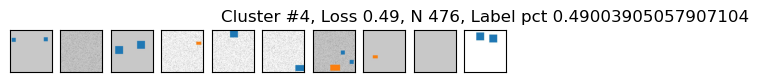

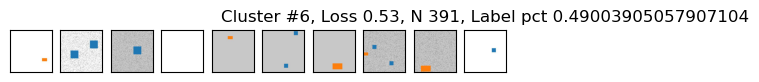

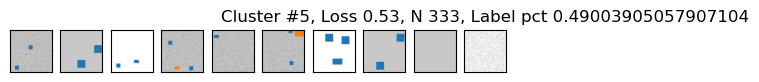

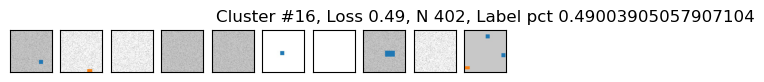

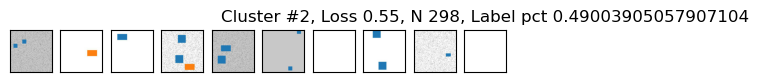

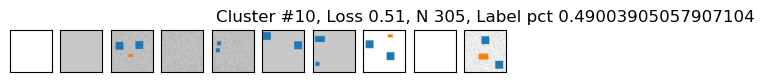

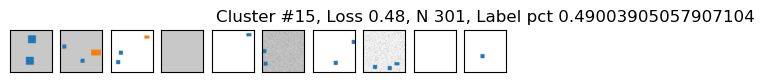

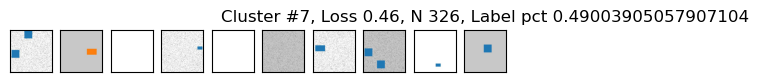

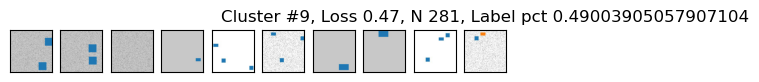

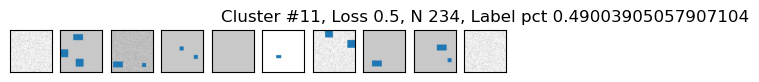

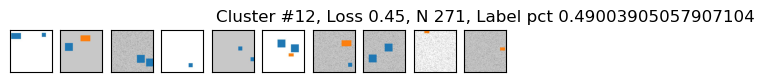

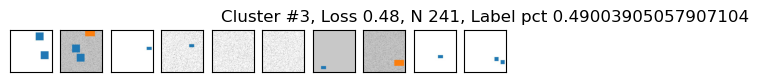

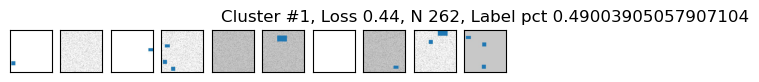

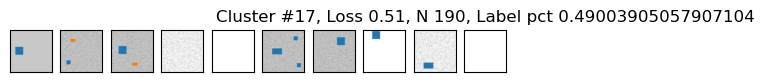

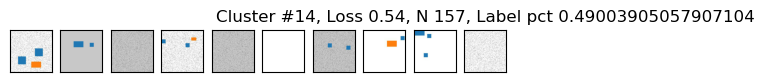

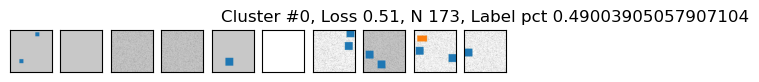

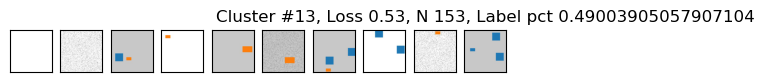

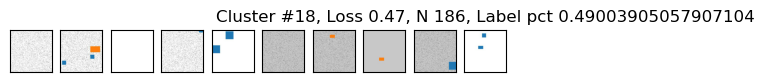

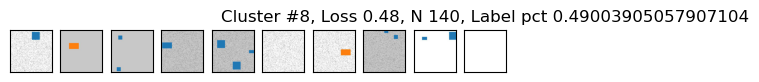

In [26]:
cluster_size_min = 25
num_imgs = 10
for j, slice_idx in enumerate(slice_indices):
    if len(cluster_map[slice_idx]) < cluster_size_min:
        continue
    fig, axs = plt.subplots(1, num_imgs)
    img_inds = np.random.choice(cluster_map[slice_idx], num_imgs, replace=False)
    this_cluster_indices = cluster_map[slice_idx]
   
    for i in range(num_imgs):
        img = Image.open(np.array(test_files)[one_inds][img_inds[i]])
        axs[i].imshow(img)
        axs[i].set_xticks([])
        axs[i].set_yticks([])

    plt.title("Cluster #{}, Loss {:.2}, N {}, Label pct {}".format(
        slice_idx,
        test_01_loss[one_inds][this_cluster_indices].mean(),
        len(cluster_map[slice_idx]),
        test_labels[one_inds].mean()
        ))
    
plt.show()